In [1]:
#biblioteki i funkcje
SEED_NUM=0
import os 
os.environ['PYTHONHASHSEED']=str(SEED_NUM)

#moje
import time

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import winsound
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation,LSTM
from tensorflow.keras.activations import relu, elu, sigmoid
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import datetime as dt 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def write(frame,name):
    writer=pd.ExcelWriter(name+'.xlsx')
    frame.to_excel(writer)
    writer.close()
    
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(SEED_NUM)
    tf.random.set_seed(SEED_NUM)    
    np.random.seed(SEED_NUM)
    random.seed(SEED_NUM)

C:\Users\Filip\AppData\Local\Temp\ipykernel_14740\2849605755.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def add_cyclic(df, var, replace = False):
    df['sin_'+var] = np.sin(2*np.pi*df[var]/max(df[var]))
    df['cos_'+var] = np.cos(2*np.pi*df[var]/max(df[var]))
    if (replace): df.drop(columns=var)

def load_data(minmax_in, minmax_out):
    df = pd.read_csv('processed.csv')
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.astype({"date": 'datetime64[ns]'})

    #Cyclic variables
    for var in ['h','m','d','wd']:
        add_cyclic(df, var)

    if(minmax_in):
        for var in [x for x in df.columns if x not in ['date','demand']]:
            mx = max(df[var])
            mn = min(df[var])
            df[var] = (df[var] - mn) / (mx-mn)
        print("Potential input data normalized")
    if (minmax_out):
        var = 'demand'
        mx = max(df[var])
        mn = min(df[var])
        df[var] = (df[var] - mn) / (mx-mn)
        print("Output data normalized")

    #df_train1 = df[df.y.isin([2011,2010])]
    #df_train2 = df[df.y!=2012]
    #test = df_test = df[df.y==2012]
    df_train1 = df[df.date.dt.year.isin([2011,2010])]
    df_train2 = df[df.date.dt.year!=2012]
    test = df_test = df[df.date.dt.year==2012]
    print(f'Test data 2012')

    val1 = df_train1.sample(frac=1/7, random_state = 1)
    mask = [False if x in val1.index else True for x in df_train1.index]
    train1 = df_train1.loc[mask]
    total_size = test.shape[0] + train1.shape[0] + val1.shape[0]
    print(f'Split 1: Training data 2010, 2011 \n____ training size: {train1.shape[0]} {100*train1.shape[0]/total_size:.2f}%' + 
        f'\n____ validation size: {val1.shape[0]} {100*val1.shape[0]/total_size:.2f}%' +
        f'\n____ test size: {test.shape[0]} {100*test.shape[0]/total_size:.2f}%')

    val2 = df_train2.sample(frac=1/7, random_state = 1)
    mask = [False if x in val2.index else True for x in df_train2.index]
    train2 = df_train2.loc[mask]
    total_size = test.shape[0] + train2.shape[0] + val2.shape[0]
    print(f'Split 1: Training data 2009, 2010, 2011 \n____ training size: {train2.shape[0]} {100*train2.shape[0]/total_size:.2f}%' + 
        f'\n____ validation size: {val2.shape[0]} {100*val2.shape[0]/total_size:.2f}%' +
        f'\n____ test size: {test.shape[0]} {100*test.shape[0]/total_size:.2f}%')
    return train1, val1, train2, val2, test



In [3]:
def convert_to_values(train, val, test, in_vars):
    out = 'demand'
    in_tr = train[in_vars].values.reshape(train.shape[0],1,len(in_vars))
    out_tr = train[out].values.reshape(train.shape[0],1,1)

    in_val = val[in_vars].values.reshape(val.shape[0],1,len(in_vars))
    out_val = val[out].values.reshape(val.shape[0],1,1)

    in_test = test[in_vars].values.reshape(test.shape[0], 1, len(in_vars))
    out_test = test[out].values.reshape(test.shape[0],1,1)

    in_tr = in_tr.astype('float64')
    in_val = in_val.astype('float64')
    in_test = in_test.astype('float64')

    return in_tr, out_tr, in_val, out_val, in_test, out_test

In [4]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    fig = plt.gcf()
    plt.show()
    return fig

def train_model(model, epo, early_stopping, in_tr, out_tr, in_val, out_val, batch_size=128, verbose=1):
    start = time.time()
    history=model.fit(in_tr, out_tr,validation_data=(in_val,out_val),epochs=epo,batch_size=batch_size,verbose=verbose,shuffle=True,callbacks=[early_stopping]) 
    end = time.time()
    ucz=history.history['loss'][-1]
    spr=history.history['val_loss'][-1]
    fig = plot_history(history)
    t = end-start
    return history, ucz, spr, fig, t

def eval_model(model, in_test, out_test, batch_size=128):
    score = model.evaluate(in_test, out_test, batch_size=batch_size) #instrukcja testowania modelu
    return score

def prognose(model, in_data, out_data):
    prognosis=model.predict(in_data, batch_size=None, verbose=0, steps=None) #wpisać jak chce się wartości przewidywane uzyskać
    prognosis2=prognosis.flatten().tolist()
    out_data2=out_data.flatten().tolist()
    out=pd.DataFrame(list(zip(prognosis2,out_data2)))
    out.columns=['prognosis','reals']
    return out

In [53]:
from datetime import datetime
from uuid import uuid4

def get_naive(out, shift=24):
    p = pd.DataFrame()
    p['reals'] = out.flatten()
    p['prognosis'] = p['reals'].shift(shift)
    p = p.dropna()
    err = p['prognosis'] - p['reals']
    abs_err = abs(err)
    mae = np.average(abs_err)
    nmae = mae/np.sum(abs(p['reals']))
    aemin = min(abs_err)
    aemax = max(abs_err)
    return mae, nmae, aemin, aemax

def get_errors(model, in_df, out_df):
    p = prognose(model, in_df, out_df)
    err = p['prognosis'] - p['reals']
    abs_err = abs(err)
    mae = np.average(abs_err)
    nmae = mae/np.sum(abs(p['reals']))
    aemin = min(abs_err)
    aemax = max(abs_err)
    return mae, nmae, aemin, aemax

def net_id_generator():
    i=0
    while(True):
        i+=1
        yield i

results_df = pd.DataFrame(columns = ['net_id','n_layers', 'layer_types', 'layer_units','layer_activations','optimizer','lr',
                                     'epochs_set','epochs_stop','epochs_minval','hist_min_loss_val',
                                     'mae_val','nmae_val','aemin_val','aemax_val',
                                     'mae_test','nmae_test','aemin_test','aemax_test',
                                     'tr_time','rnd_seed','dataset_id','in_vars',
                                     'timestamp','comment','opt_conf','batch_size','norm'])
id_gen = net_id_generator()
Models = []
Figures = []
Optimizers = []

In [6]:
def save_results_df(results_df, Models, Figures, Optimizers, model, opt, epo, in_val, out_val, in_test, out_test, hist, t, f, dataset_id, in_vars, id_gen, batch_size, norm_in, norm_out):
    layers = model.layers
    n_layers = len(layers)
    l_types = []
    l_units = []
    l_act = []
    for layer in layers:
        conf = layer.get_config()
        #str(type(layers[1])).split('.')[-1].split("'")[0]
        l_types.append(conf['name'].split('_')[0])
        l_units.append(conf['units'])
        l_act.append(conf['activation'])
    conf = opt.get_config()
    opt_str = conf['name']
    lr = conf['learning_rate']
    epo
    epo_opt = np.argmin(hist.history['val_loss'])+1
    epo_stop = len(hist.history['loss'])
    mae_val, nmae_val, aemin_val, aemax_val = get_errors(model, in_val, out_val)
    mae_test, nmae_test, aemin_test, aemax_test = get_errors(model, in_test, out_test)

    Models.append(model)
    Figures.append(f)
    Optimizers.append(opt)
    results_df.loc[len(results_df.index)] = [next(id_gen), n_layers, l_types, l_units, l_act, opt_str, lr,
                                          epo, epo_stop, epo_opt, min(hist.history['val_loss']),
                                          mae_val, nmae_val, aemin_val, aemax_val,
                                          mae_test, nmae_test, aemin_test, aemax_test,
                                            t, SEED_NUM, dataset_id, in_vars,
                                            time.time(),'',conf, batch_size, str(norm_in) + " " + str(norm_out)] 
def save_results_csv(results_df):
    name = 'ResData_'+datetime.now().strftime('%Y_%m_%d-%H_%M_%S')+'_'+uuid4().hex
    write(results_df, name)

def add_comment(results_df, comment, net_id = None):
    if (net_id == None):
        net_id = max(results_df.net_id)
    results_df.loc[results_df['net_id'] == net_id,'comment'] = comment

In [7]:
minmax_in = True
minmax_out = True
train1, val1, train2, val2, test = load_data(minmax_in, minmax_out)

Potential input data normalized
Output data normalized
Test data 2012
Split 1: Training data 2010, 2011 
____ training size: 15010 57.09%
____ validation size: 2502 9.52%
____ test size: 8780 33.39%
Split 1: Training data 2009, 2010, 2011 
____ training size: 22454 64.20%
____ validation size: 3742 10.70%
____ test size: 8780 25.10%


In [8]:
train1.columns

Index(['date', 'demand', 'h', 'm', 'd', 'y', 'wd', 'pkb', 'inflation',
       'pop_growth', 'tax_in', 'poor_rate', 'child_avg', 'export', 'goods_out',
       'ddc', 'gini_idx', 'articles', 'teleinf_export', 'listed_comps',
       'credit_priv', 'receive_priv', 'savings', 'demand_d-1', 'demand_d-2',
       'demand_d-3', 'demand_avgy', 'demand_avgm', 'sin_h', 'cos_h', 'sin_m',
       'cos_m', 'sin_d', 'cos_d', 'sin_wd', 'cos_wd'],
      dtype='object')

In [62]:
in_vars = ['h', 'm', 'd', 'y', 'wd', 'pkb', 'inflation',
       'pop_growth', 'tax_in', 'poor_rate', 'child_avg', 'export', 'goods_out',
       'ddc', 'gini_idx', 'articles', 'teleinf_export', 'listed_comps',
       'credit_priv', 'receive_priv', 'savings', 'demand_d-1', 'demand_d-2',
       'demand_d-3', 'demand_avgy', 'demand_avgm']

#Corr > 0.1
in_vars = ['sin_h','cos_h','y','sin_wd','cos_wd','pkb','inflation','tax_in','export','goods_out','gini_idx','listed_comps','credit_priv',
           'receive_priv','demand_d-1','demand_d-2','demand_d-3','demand_avgy','demand_avgm']

#Prev demand only
in_vars = ['demand_d-1','demand_d-2','demand_d-3','demand_avgy','demand_avgm']

#All

in_vars = ['sin_h','cos_h', 'sin_m','cos_m', 'sin_d','cos_d', 'y', 'sin_wd','cos_wd', 'pkb', 'inflation',
       'pop_growth', 'tax_in', 'poor_rate', 'child_avg', 'export', 'goods_out',
       'ddc', 'gini_idx', 'articles', 'teleinf_export', 'listed_comps',
       'credit_priv', 'receive_priv', 'savings', 'demand_d-1', 'demand_d-2',
       'demand_d-3', 'demand_avgy', 'demand_avgm']

dataset_id = 2
in_tr, out_tr, in_val, out_val, in_test, out_test = convert_to_values(train1, val1, test, in_vars) if dataset_id==1 else convert_to_values(train2, val2, test, in_vars)

In [63]:
#reset_random_seeds()
#pip install -U numpy==1.18.5  na maszynie lab
model = Sequential()

model.add(LSTM(65,return_sequences=True, input_shape=(in_tr.shape[1],in_tr.shape[2]),activation='tanh'))
model.add(LSTM(30,return_sequences=True,activation='tanh'))
model.add(Dense(1, activation='linear'))

#opt=  Adam(learning_rate=0.005)
#opt = Adagrad(learning_rate=0.08)
opt= Nadam(learning_rate=0.005)

model.compile(loss='mae',optimizer=opt)
pat=50 #5-10% maksymalnej liczby
epo=1200 #250!
early_stopping =EarlyStopping(monitor='val_loss', patience=pat)

C:\Users\Filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


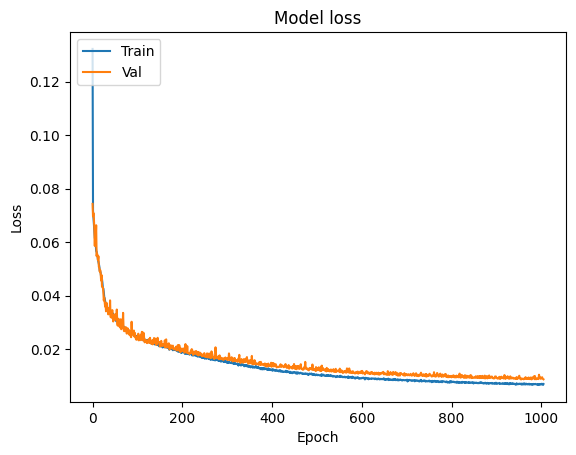

1


In [64]:
batch_size = 512
hist, ucz, spr, f, t = train_model(model, epo, early_stopping, in_tr, out_tr, in_val, out_val, batch_size, verbose=0)

for i in range(1,2):
    print(i)
    save_results_df(results_df, Models, Figures, Optimizers, model, opt, epo, in_val, out_val, in_test, out_test, hist, t, f, dataset_id, in_vars, id_gen, batch_size, minmax_in, minmax_out)

In [65]:
pd.options.display.max_columns = None
t =results_df.sort_values(by='nmae_val')
display(t[t['net_id'].between(max(t['net_id'])-2, max(t['net_id']))])
display(t.head(3))


,net_id,n_layers,layer_types,layer_units,layer_activations,optimizer,lr,epochs_set,epochs_stop,epochs_minval,hist_min_loss_val,mae_val,nmae_val,aemin_val,aemax_val,mae_test,nmae_test,aemin_test,aemax_test,tr_time,rnd_seed,dataset_id,in_vars,timestamp,comment,opt_conf,batch_size,norm
1,2,3,"[lstm, lstm, dense]","[65, 30, 1]","[tanh, tanh, linear]",nadam,0.005,1200,1006,956,0.008680,0.008744,0.000005,0.000001,0.206194,0.049713,0.000011,5.599053e-06,0.542835,272.687859,0,2,"[sin_h, cos_h, sin_m, cos_m, sin_d, cos_d, y, ...",1.734387e+09,,"{'name': 'nadam', 'learning_rate': 0.004999999...",512,True True
0,1,3,"[lstm, lstm, dense]","[65, 30, 1]","[tanh, tanh, linear]",nadam,0.005,1200,649,599,0.035725,0.037059,0.000029,0.000012,0.356995,0.040096,0.000009,1.615212e-07,0.515778,133.401166,0,1,"[demand_d-1, demand_d-2, demand_d-3, demand_av...",1.734387e+09,,"{'name': 'nadam', 'learning_rate': 0.004999999...",512,True True


,net_id,n_layers,layer_types,layer_units,layer_activations,optimizer,lr,epochs_set,epochs_stop,epochs_minval,hist_min_loss_val,mae_val,nmae_val,aemin_val,aemax_val,mae_test,nmae_test,aemin_test,aemax_test,tr_time,rnd_seed,dataset_id,in_vars,timestamp,comment,opt_conf,batch_size,norm
1,2,3,"[lstm, lstm, dense]","[65, 30, 1]","[tanh, tanh, linear]",nadam,0.005,1200,1006,956,0.008680,0.008744,0.000005,0.000001,0.206194,0.049713,0.000011,5.599053e-06,0.542835,272.687859,0,2,"[sin_h, cos_h, sin_m, cos_m, sin_d, cos_d, y, ...",1.734387e+09,,"{'name': 'nadam', 'learning_rate': 0.004999999...",512,True True
0,1,3,"[lstm, lstm, dense]","[65, 30, 1]","[tanh, tanh, linear]",nadam,0.005,1200,649,599,0.035725,0.037059,0.000029,0.000012,0.356995,0.040096,0.000009,1.615212e-07,0.515778,133.401166,0,1,"[demand_d-1, demand_d-2, demand_d-3, demand_av...",1.734387e+09,,"{'name': 'nadam', 'learning_rate': 0.004999999...",512,True True


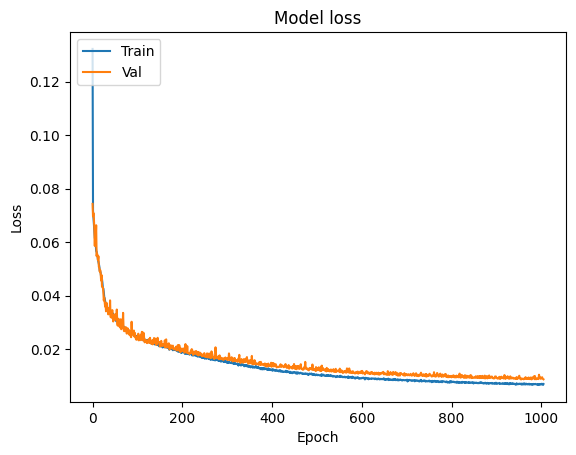

In [66]:
id = 2
Figures[id-1]

In [67]:
save = False
save = True
if (save):
    save_results_csv(results_df)

In [71]:
test['date']

26196   2012-01-01 00:00:00
26197   2012-01-01 01:00:00
26198   2012-01-01 02:00:00
26199   2012-01-01 03:00:00
26200   2012-01-01 04:00:00
                ...        
34971   2012-12-31 19:00:00
34972   2012-12-31 20:00:00
34973   2012-12-31 21:00:00
34974   2012-12-31 22:00:00
34975   2012-12-31 23:00:00
Name: date, Length: 8780, dtype: datetime64[ns]

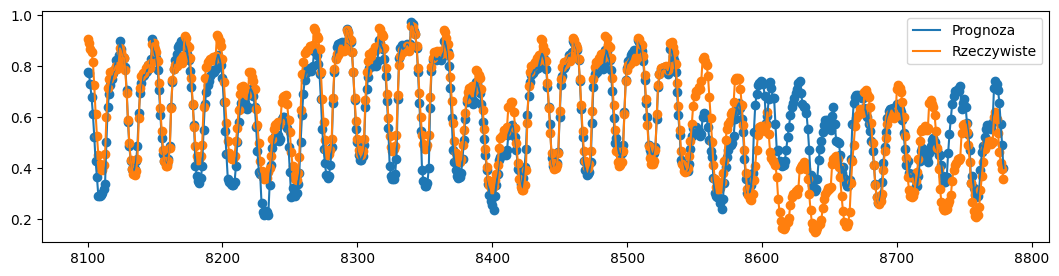

In [68]:
id = 2
model = Models[id-1]
p = prognose(model, in_test, out_test)
r = range(8100, p.shape[0])
plt.figure(figsize=(13,3))
plt.plot(r, p.loc[r, 'prognosis'], label = 'Prognoza')
plt.scatter(r, p.loc[r, 'prognosis'])
plt.plot(r, p.loc[r,'reals'], label = 'Rzeczywiste')
plt.scatter(r, p.loc[r,'reals'])
plt.legend(loc='upper right')
plt.show()

In [55]:
print(get_naive(out_test, shift=24))
print(get_naive(out_test, shift=1))

(0.07705588426546754, 1.6913201063497844e-05, 1.493998895174542e-05, 0.47518185356299925)
(0.03874870511877597, 8.491846857824521e-06, 4.707979711665589e-06, 0.19617599055893153)


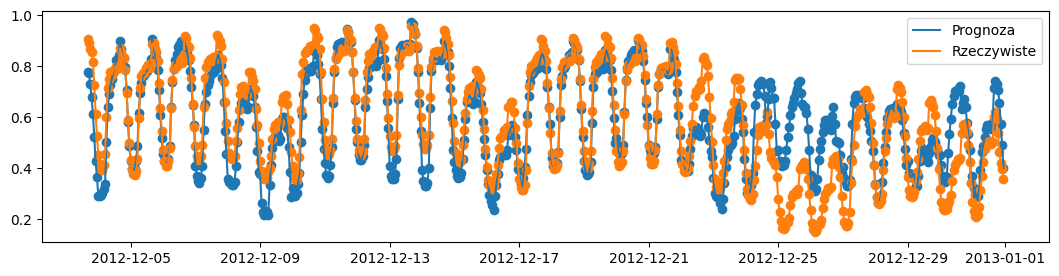

In [76]:
id = 2
model = Models[id-1]
p = prognose(model, in_test, out_test)
p.index = test['date']
r = test['date'].iloc[range(8100, p.shape[0])]
plt.figure(figsize=(13,3))
plt.plot(r, p.loc[r, 'prognosis'], label = 'Prognoza')
plt.scatter(r, p.loc[r, 'prognosis'])
plt.plot(r, p.loc[r,'reals'], label = 'Rzeczywiste')
plt.scatter(r, p.loc[r,'reals'])
plt.legend(loc='upper right')
plt.show()